# Simulation Sandbox

#### Objective 🎯

This notebook aims to familiarize the workshop participants with the simulation environment used in the workshop.

**Tools of the trade**
- [pyswmm](https://www.pyswmm.org): pyswmm is a Python wrapper for controlling EPA-SWMM's simulation engine. pyswmm is available in PyPI and on GitHub. pyswmm enables us to pause the simulation, query the states, make the necessary modification, and resume the simulation. We rely on pyswmm for simulating real-time control in stormwater systems. EPA-SWMM's solver uses the dynamics wave equation for routing flows in the stormwater network. This solver enables us to simulate hydraulic phenomena like backwater propagation which can arise with control. This makes EPA SWMM an ideal choice for simulating control in stormwater systems.
- [swmmio](https://swmmio.readthedocs.io/en/v0.6.6/): swmmio helps us update input files, read output and report files, and visualize the network topology 
- [pystorms](https://www.pystorms.org): pystorms is a collection of real-world inspired stormwater networks for evaluating and developing real-time control algorithms. 

We will also be using several other amazing Python libraries like **numpy**, **pandas**, **scikit-learn** and **matplotlib**. 

In [ ]:
pip install pyswmm swmmio pystorms matplotlib pandas

In [28]:
# import libs
import pyswmm
import swmmio
import pystorms
import matplotlib.pyplot as plt

In [29]:
# RC parms for pretty plots 💁🏽
plt.rcParams.update({'font.size': 20})
plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('seaborn-v0_8-dark-palette')

For this example, we will use a synthetic stormwater network with two basins draining into an outlet. The image below represents the network's topology and flow at the network outlet during a storm event.

![Theta](./data/theta.png)

### Exercise - 1
#### Simulating a stormwater network in EPA-SWMM in Python using pyswmm

In [30]:
# NOTE: If you are unfamiliar with input files, EPA-SWMM uses a input file to represent the network topology 
# and forcing events like rainfall and dry-weather flows.

# Load the input file from pystorms.
input_file = pystorms.load_network("theta")
print(f"SWMM input file path: {input_file}")

SWMM input file path: /Users/amullap/Archive/dev/venv/lib/python3.9/site-packages/pystorms/networks/theta.inp


👆 pystorms is just providing the path to the input file.

In [31]:
# Once we have the stormwater network, we hand over the input file to the awesome pyswmm
# pyswmm helps us control EPA-SWMM from python, so that we don't have to press buttons in a GUI anymore 😆
simulation = pyswmm.Simulation(inputfile=input_file)

# run the simulation
simulation.execute()


... SWMM Version 5.1.14
 o  Retrieving project data
 o  Retrieving project data
... Run Complete

👨🏼‍🎓 **Exercise 1.1** : Try running a simulation with another stormwater network from pystorms or may be one of your own stormwater networks.

pystorms has the following stormwater networks: *theta, alpha, beta, gamma, delta, epsilon, zeta*

See https://www.pystorms.org/docs/build/html/scenarios.html for additional information on the available stormwater networks.

In [32]:
input_file_bonus_question = pystorms.load_network("")
## Your awesome code goes here!

ValueError: Undefined Network, please refer to the documentation

### Exercise - 2
#### Interactive simulation of stormwater networks

The power of pyswmm is its ability to control the SWMM solver from Python. Using pyswmm, we can stop the simulation midway, make changes, and resume it. It also enables us to link SWMM with Python libraries like Pytorch and Numpy and create novel solutions. We will see more on this in the later part of the workshop.  

In [33]:
# pyswmm gives us the power to intervean during the simulation and make changes
input_file = pystorms.load_network("theta")
simulation = pyswmm.Simulation(inputfile=input_file)

for step in simulation:
    # pyswmm returns current step as python's datetime object
    print(f"Simulation Time: {simulation.current_time}")

simulation.close()

Simulation Time: 2018-02-25 00:00:01
Simulation Time: 2018-02-25 00:00:31
Simulation Time: 2018-02-25 00:01:01
Simulation Time: 2018-02-25 00:01:31
Simulation Time: 2018-02-25 00:02:01
Simulation Time: 2018-02-25 00:02:31
Simulation Time: 2018-02-25 00:03:01
Simulation Time: 2018-02-25 00:03:31
Simulation Time: 2018-02-25 00:04:01
Simulation Time: 2018-02-25 00:04:31
Simulation Time: 2018-02-25 00:05:01
Simulation Time: 2018-02-25 00:05:31
Simulation Time: 2018-02-25 00:06:01
Simulation Time: 2018-02-25 00:06:31
Simulation Time: 2018-02-25 00:07:01
Simulation Time: 2018-02-25 00:07:31
Simulation Time: 2018-02-25 00:08:01
Simulation Time: 2018-02-25 00:08:31
Simulation Time: 2018-02-25 00:09:01
Simulation Time: 2018-02-25 00:09:31
Simulation Time: 2018-02-25 00:10:01
Simulation Time: 2018-02-25 00:10:31
Simulation Time: 2018-02-25 00:11:01
Simulation Time: 2018-02-25 00:11:31
Simulation Time: 2018-02-25 00:12:01
Simulation Time: 2018-02-25 00:12:31
Simulation Time: 2018-02-25 00:13:01
S

Building on this example, let us see what else we can do

In [34]:
# Create data loggers
simulation_time = []
depth = []
flows = []

# Open the simulation
input_file = pystorms.load_network("theta")

# Note: with statement is an other way to use pyswmm
with pyswmm.Simulation(inputfile=input_file) as sim:
    # Initialize nodes and links objects
    nodes = pyswmm.Nodes(sim)
    link = pyswmm.Links(sim)
    
    # Specify the link or nodes that we are interested in monitoring
    node_P1 = nodes['P1']
    link_8 = link['8']
    orifice_P1 = link['1']
    
    # Progress through the simulation
    for step in sim:
        # Log the simulation time
        simulation_time.append(sim.current_time)
        
        # Log the depth and low
        depth.append(node_P1.depth)
        flows.append(link_8.flow)


 o  Retrieving project data

Let us plot and see what is happening in the system

Text(0.5, 0, 'Simulation Time')

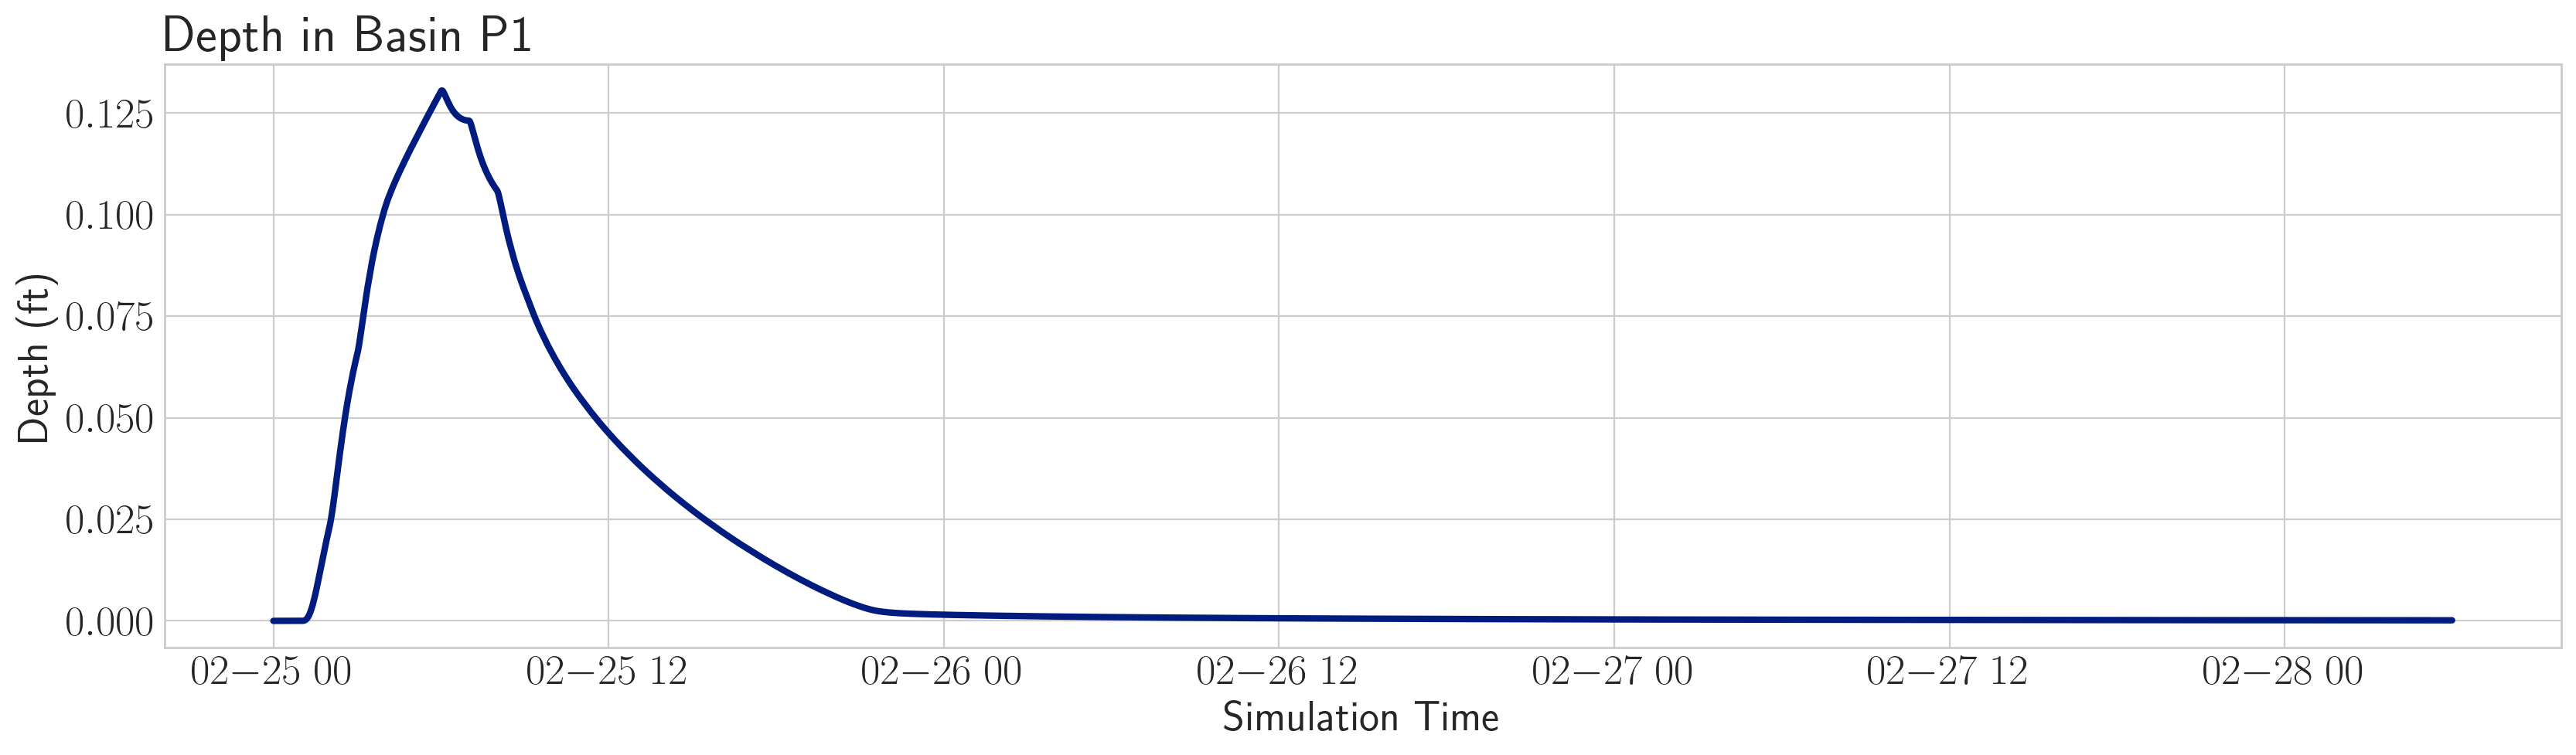

In [35]:
plt.figure(figsize=(20, 5), dpi=200)
plt.plot(simulation_time, depth, linewidth=3.0)
plt.title("Depth in Basin P1", loc='left')
plt.ylabel("Depth (ft)")
plt.xlabel("Simulation Time")

👨🏼‍🎓 **Exercise 2.1**

Building on the above code, plot the water level in the Node P2.

*Note*: P1 and P2 are the basins in network theta, represented by the orange nodes in the image above.

In [36]:
# Get the input file
input_file = pystorms.networks.load_network("theta")

# Create lists for logging data


# Initalize the simulation object
with pyswmm.Simulation(inputfile=input_file) as sim:
    # <your code goes here>
    pass


 o  Retrieving project data

#### Pro-tip 🧘🏽‍♀️
**Reading output files**

pyswmm can process simulation data from the output file generated by EPA-SWMM. The following example illustrates this functionality

In [37]:
# Import pyswmm output parser module and object the informs the which datatype to pull from the output file
from pyswmm import Output
from swmm.toolkit.shared_enum import NodeAttribute

For more information, refer http://pyswmm.github.io/pyswmm/reference/output.html

We will use pandas to help us deal timeseries 🐼

In [38]:
import pandas as pd

In [39]:
# get the path of the output file
output_file = input_file[:-3] + "out"

In [40]:
print(f"Path of the output file: {output_file}")

Path of the output file: /Users/amullap/Archive/dev/venv/lib/python3.9/site-packages/pystorms/networks/theta.out


In [41]:
output_object = Output(output_file)
depth = output_object.node_series("P1", attribute=NodeAttribute.INVERT_DEPTH)
depth = pd.DataFrame(data={"P1 Depth": depth.values()}, index=depth.keys())

Text(0.5, 0, 'Simulation Time')

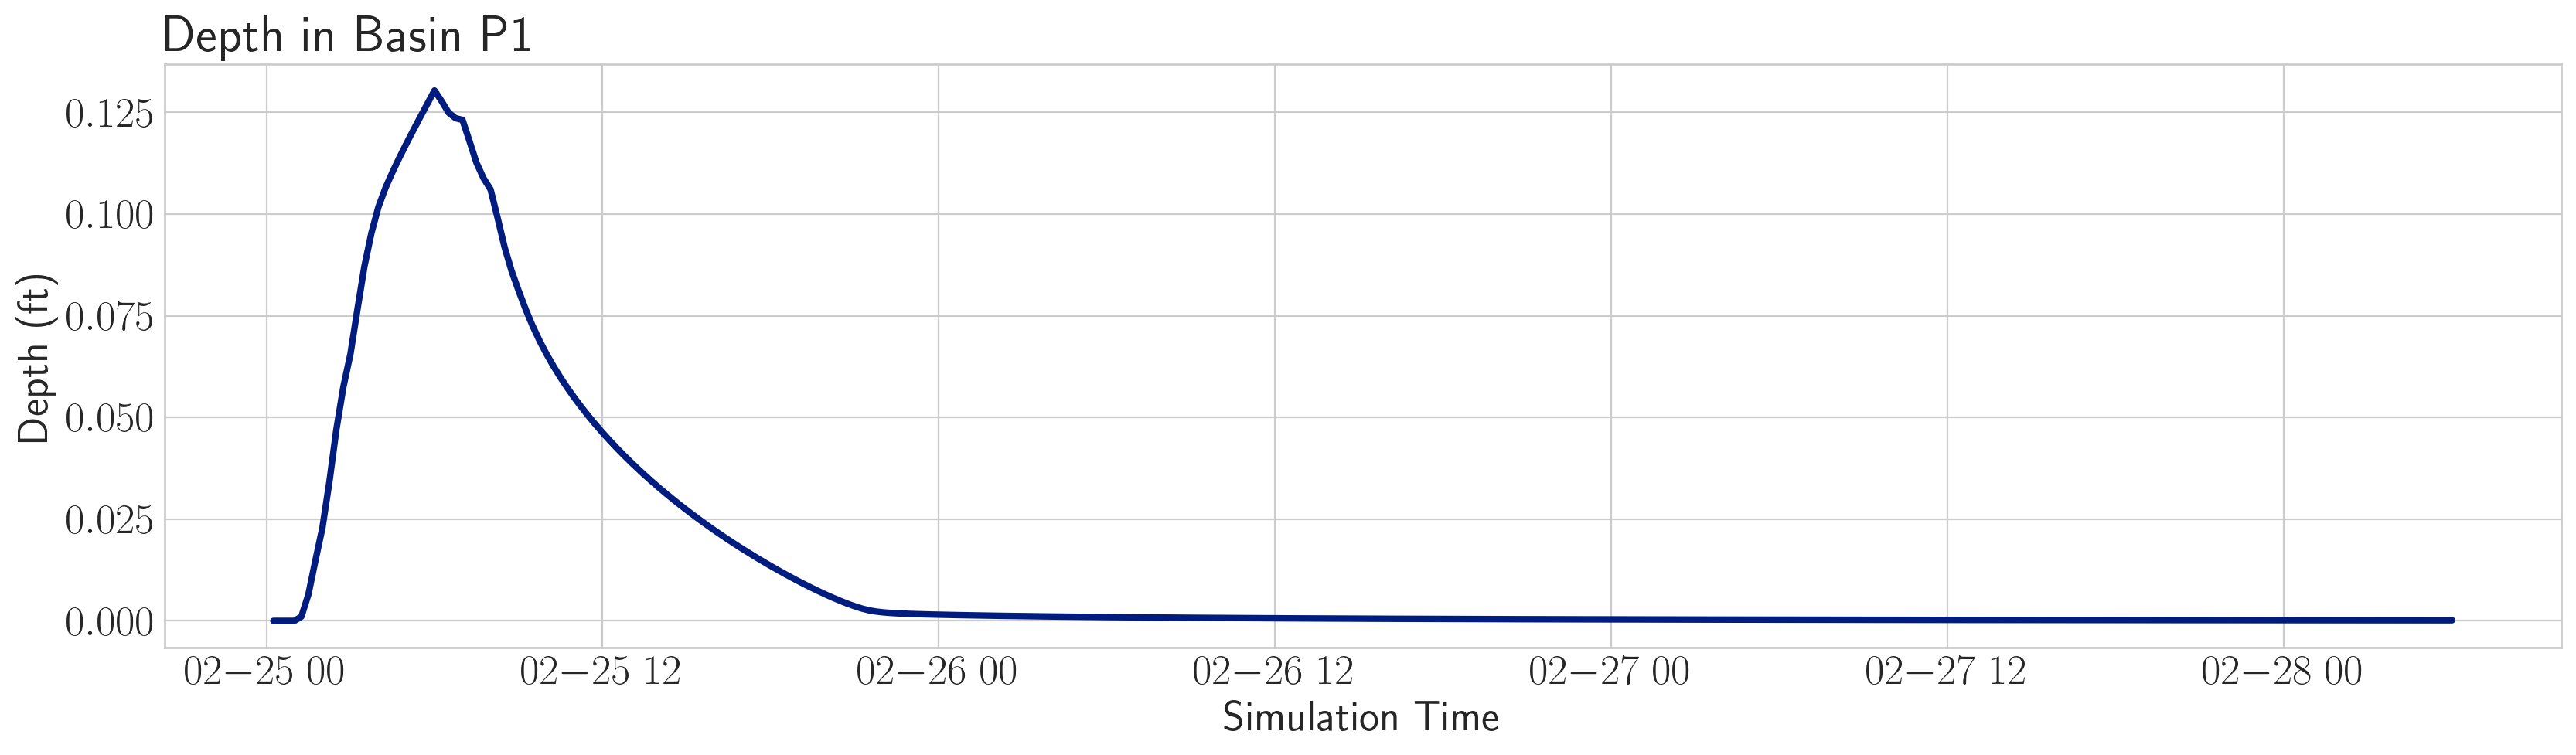

In [42]:
plt.figure(figsize=(20, 5), dpi=200)
plt.plot(depth, linewidth=3.0)
plt.title("Depth in Basin P1", loc='left')
plt.ylabel("Depth (ft)")
plt.xlabel("Simulation Time")

### Exercise - 3
#### Real-time control of stormwater networks 🤯

The interactive nature of pyswmm enables us to implement real-time control strategies. This feature has helped us develop and deploy stormwater control algorithms worldwide.

In [43]:
# Load the input file
input_file = pystorms.networks.load_network("theta")

depth = []
flow = []
simulation_time = []
with pyswmm.Simulation(inputfile=input_file) as sim:
    # Initialize nodes and links objects
    nodes = pyswmm.Nodes(sim)
    link = pyswmm.Links(sim)
    
    # Specify the link or nodes that we are interested in monitoring
    node_P1 = nodes['P1']
    link_8 = link['8']
    orifice_P1 = link['1']
    # Progress through the simulation
    for step in sim:
        # Log the simulation time
        simulation_time.append(sim.current_time)
        
        basin_P1_depth = node_P1.depth
        
        # A simple control action to hold the water in the basin
        if basin_P1_depth <= 0.10:
            orifice_P1.target_setting = 0.0
        else:
            orifice_P1.target_setting = 1.0
        
        # Log basin depth and flow
        depth.append(basin_P1_depth)
        flow.append(link_8.flow)

swig/python detected a memory leak of type 'struct Handle *', no destructor found.

 o  Retrieving project data

Text(0.5, 0, 'Simulation Time')

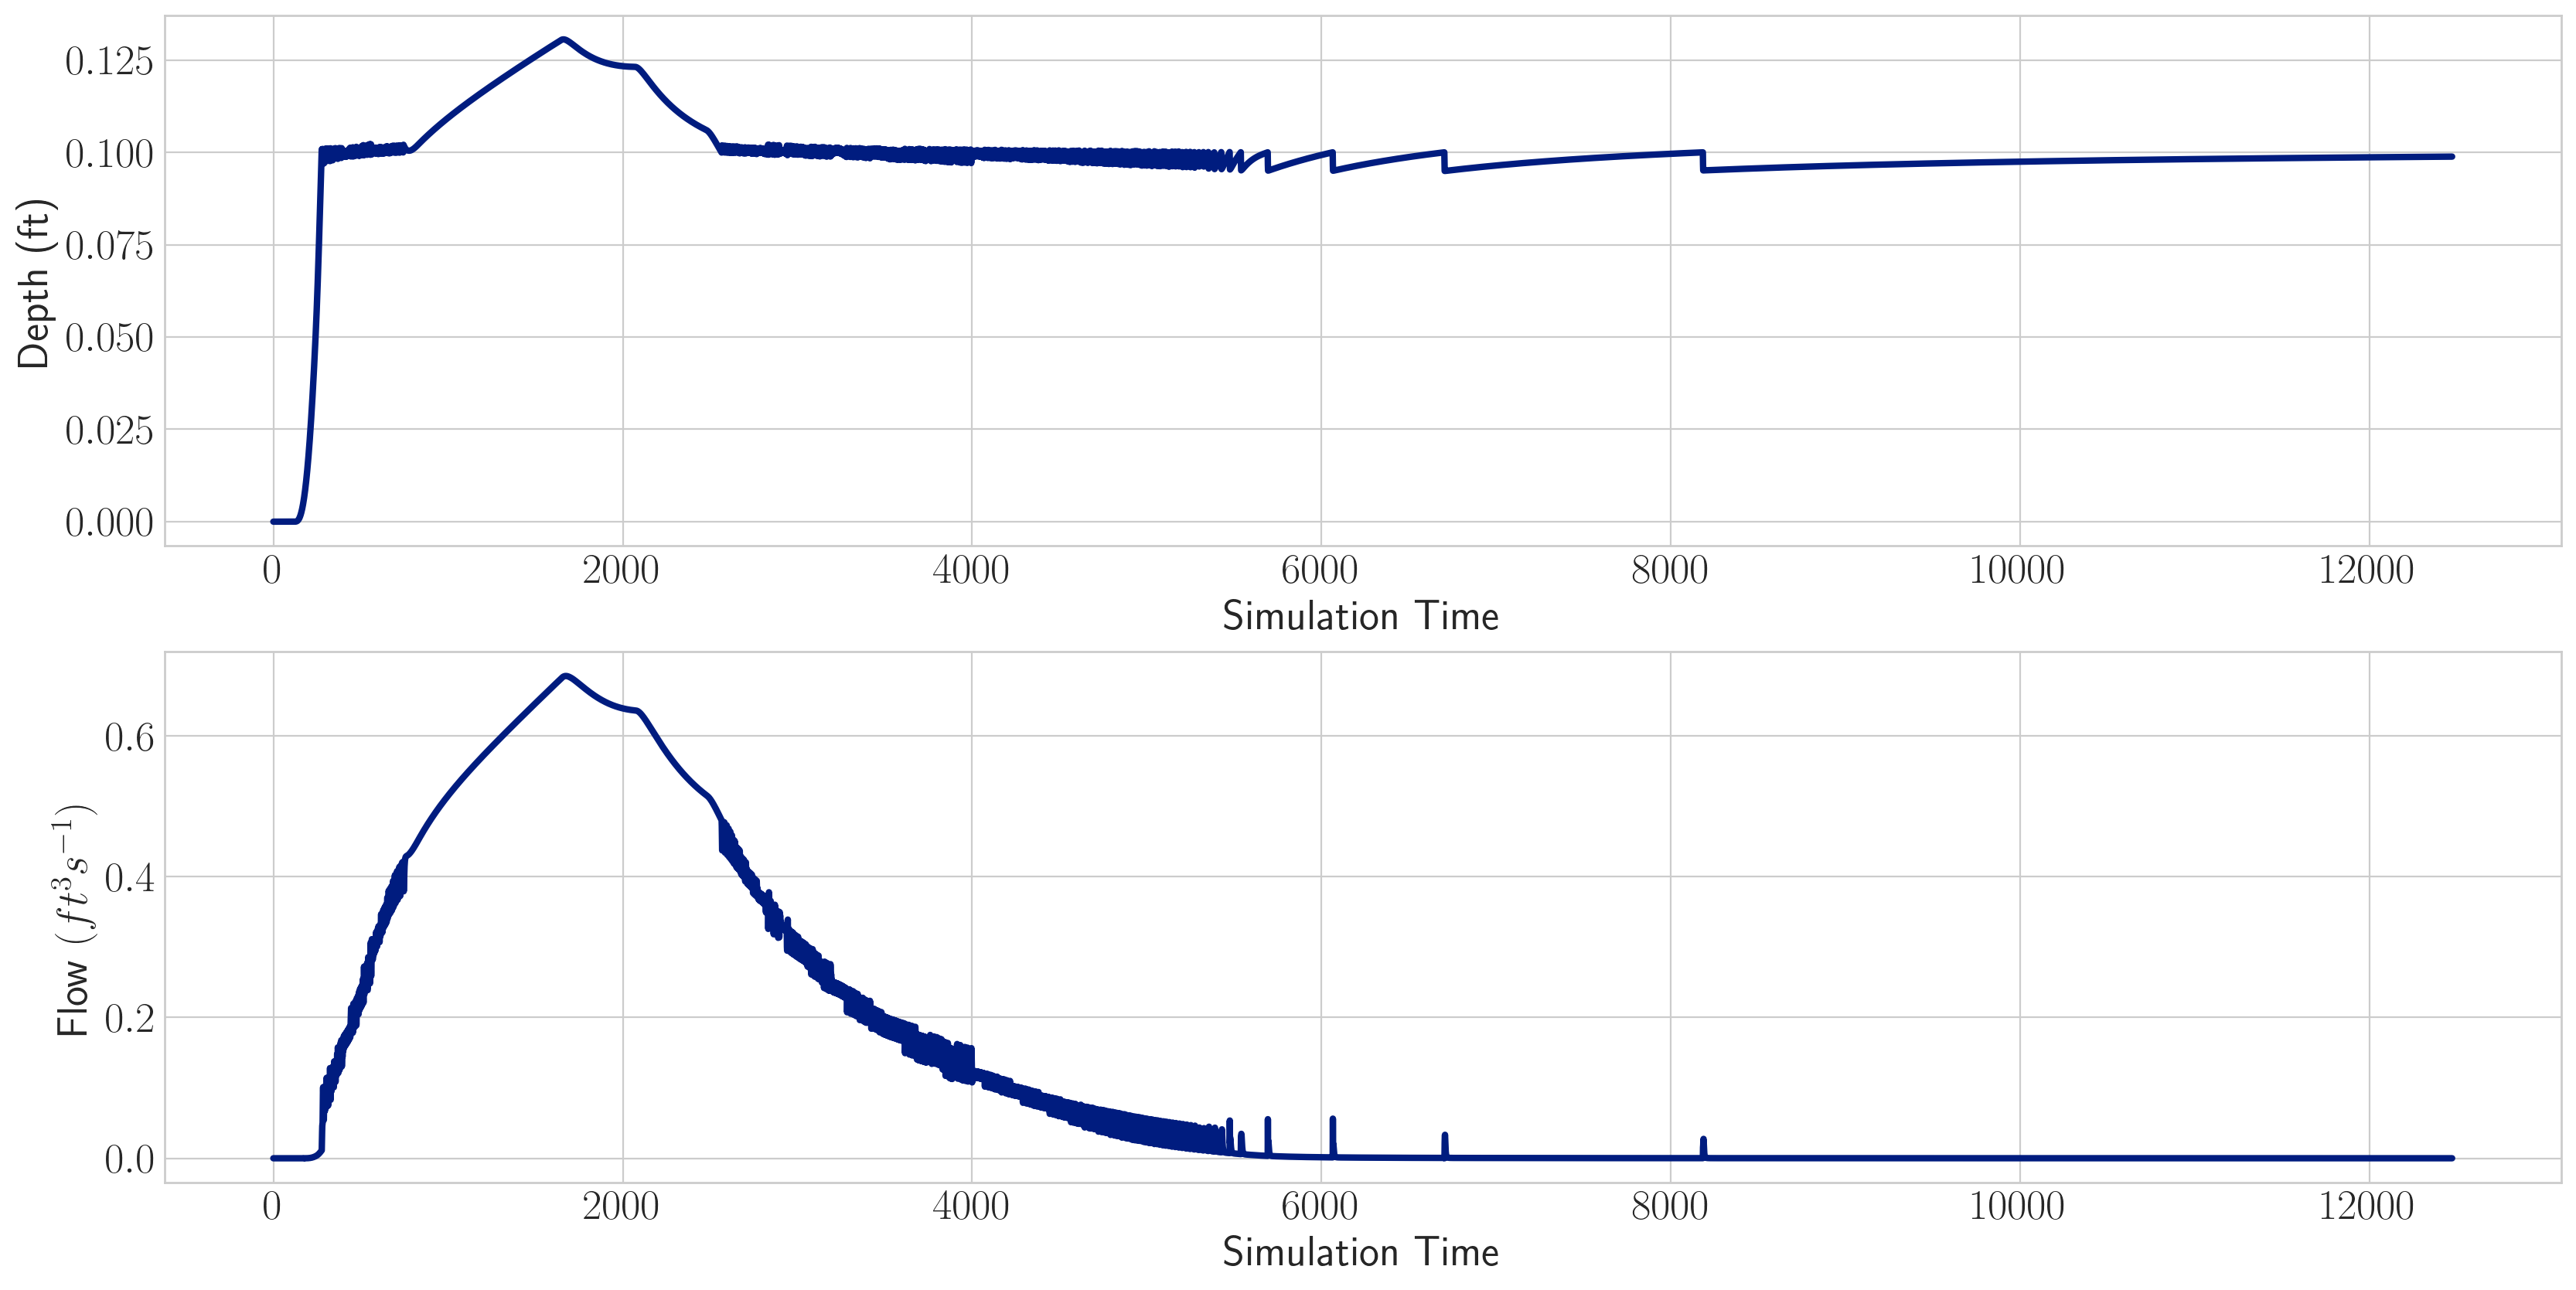

In [44]:
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot(2, 1, 1)
plt.plot(depth, linewidth=3.0)
plt.ylabel("Depth (ft)")
plt.xlabel("Simulation Time")

plt.subplot(2, 1, 2)
plt.plot(flow, linewidth=3.0)
plt.ylabel(r"Flow $(ft^{3}s^{-1})$")
plt.xlabel("Simulation Time")